<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Localizacao-e-Uso-da-Informacao--IMDB/blob/main/trabalhoLUI_IMDB_Codigo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import lxml
import re
import numpy as np
import pandas as pd
import requests
import string
import seaborn as sns
import matplotlib.pyplot as plt
import typing

from bs4 import BeautifulSoup

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

url1 = 'https://www.imdb.com/search/title?count=100&title_type=feature,tv_series&ref_=nv_wl_img_2'

## 1 - Encontrar o padrão da URL

In [ ]:
response = requests.get(url1, headers=headers)
soup = BeautifulSoup(response.text,'html.parser')

In [ ]:
movies = soup.find('div', attrs={'class': 'desc'}).get_text() # <----- Busca o número total de filmes (imagem 1)

In [ ]:
punc_re = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', str(x).lower())
movies = punc_re(movies)
movies = [float(s) for s in re.findall(r'-?\d+\.?\d*', movies)]
movies = int(movies[1])

In [ ]:
print('Número total de filmes: ', movies)

Número total de filmes:  657325


In [ ]:
url_list = [url1] # <---- url1 não segue o padrão das páginas seguintes
start = 1
for i in range(0,movies,100):       ### --->>> Cada página contém 100 filmes <<<---
    start +=100
    url_list.append('https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start='+str(start)+'&ref_=adv_nxt')
print(url_list[3])

https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start=301&ref_=adv_nxt


## 2 - Executar webscraping do número de páginas (n) desejado e criar dataframe com as informações

In [ ]:
### Definir número de páginas ###
n = 100

In [ ]:
### Função para executar webscraping ###
class IMDB(object):
	"""docstring for IMDB"""
	def __init__(self, url):
		super(IMDB, self).__init__()
		page = requests.get(url)

		self.soup = BeautifulSoup(page.content, 'lxml')

	def articleTitle(self):
		return self.soup.find("h1", class_="header").text.replace("\n","")

	def bodyContent(self):
		content = self.soup.find(id="main")
		return content.find_all("div", class_="lister-item mode-advanced")

	def movieData(self):
		movieFrame = self.bodyContent()
		movieTitle = []
		movieDate = []
		movieRunTime = []
		movieGenre = []
		movieRating = []
		movieScore = []
		movieDescription = []
		movieDirector = []
		movieStars = []
		movieVotes = []
		movieGross = []
		for movie in movieFrame:
			
			movieFirstLine = movie.find("h3", class_="lister-item-header")
			
			movieTitle.append(movieFirstLine.find("a").text)
			
			movieDate.append(re.sub(r"[()]","", movieFirstLine.find_all("span")[-1].text))

			try:
				movieRunTime.append(movie.find("span", class_="runtime").text[:-4])
			except:
				movieRunTime.append(np.nan)

			try:
				movieGenre.append(movie.find("span", class_="genre").text.rstrip().replace("\n","").split(","))
			except:
				movieGenre.append(np.nan)

			try:
				movieRating.append(movie.find("strong").text)
			except:
				movieRating.append(np.nan)
			
			try:
				movieScore.append(movie.find("span", class_="metascore unfavorable").text.rstrip())
			except:
				movieScore.append(np.nan)
			
			movieDescription.append(movie.find_all("p", class_="text-muted")[-1].text.lstrip())
			
			movieCast = movie.find("p", class_="")
			try:
				casts = movieCast.text.replace("\n","").split('|')
				casts = [x.strip() for x in casts]
				casts = [casts[i].replace(j, "") for i,j in enumerate(["Director:", "Stars:"])]
				movieDirector.append(casts[0])
				movieStars.append([x.strip() for x in casts[1].split(",")])
			except:
				casts = movieCast.text.replace("\n","").strip()
				movieDirector.append(np.nan)
				movieStars.append([x.strip() for x in casts.split(",")])

			movieNumbers = movie.find_all("span", attrs={"name": "nv"})

			if len(movieNumbers) == 2:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(movieNumbers[1].text)
			elif len(movieNumbers) == 1:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(np.nan)
			else:
				movieVotes.append(np.nan)
				movieGross.append(np.nan)

		movieData = [movieTitle, movieDate, movieRunTime, movieGenre, movieRating, movieScore, movieDescription, movieDirector, movieStars,movieVotes, movieGross]
		return movieData

In [ ]:
if __name__ == '__main__':
	movies_df = pd.DataFrame()
	for i in range(n):  # <------ Número de páginas (n)
		url = url_list[i]
		site = IMDB(url)
		data = site.movieData()
		df = pd.DataFrame(data)	
		df = df.transpose()
		movies_df = movies_df.append(df, ignore_index=True)
	columns = ['movietitle', 'moviedate', 'movieruntime', 'moviegenre', 'movierating', 'moviescore', 'moviedescription', 'moviedirector', 'moviestars', 'movievotes', 'moviegross']
	movies_df.columns = columns

#### Salvar o dataframe sem tratamento dos dados em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Movies_Raw.csv')
movies_df.to_csv('Movies_Raw.zip', index=True, compression=compression_opts, encoding='windows-1252')

In [ ]:
movies_df.tail(10)

,movietitle,moviedate,movieruntime,moviegenre,movierating,moviescore,moviedescription,moviedirector,moviestars,movievotes,moviegross
9990,Verotika,2019,90,[Horror],1.9,NaN,Follows the surreal and bloody trilogy of erot...,Glenn Danzig,"[Ashley Wisdom, Rachel Alig, Alice Tate, Kayde...","1,329",NaN
9991,Frequency,2016–2017,42,"[Drama, Fantasy, Mystery]",7.5,NaN,A police detective in 2016 discovers that she ...,NaN,"[Stars:Peyton List, Riley Smith, Devin Kelley,...","12,765",NaN
9992,O Confronto Final,1981,106,"[Action, Thriller]",7.2,NaN,"During a routine exercise, a team of National ...",Walter Hill,"[Keith Carradine, Powers Boothe, Fred Ward, Fr...","16,584",$5.00M
9993,Uma Noite em Banguecoque,2020,105,"[Action, Crime, Drama]",5.0,NaN,A hit man named Kai (Mark Dacascos) flies into...,Wych Kaosayananda,"[Mark Dacascos, Vanida Golten, Prinya Intachai...","1,437",NaN
9994,Leões e Cordeiros,2007,92,"[Crime, Drama, Mystery]",6.2,NaN,Injuries sustained by two Army rangers behind ...,Robert Redford,"[Tom Cruise, Meryl Streep, Robert Redford, Mic...","47,515",$15.00M
9995,Carga Bruta,2015,81,"[Action, Crime, Drama]",6.3,NaN,Work-life balance breaks down for Paris's most...,Julien Leclercq,"[Sami Bouajila, Guillaume Gouix, Youssef Hajdi...","4,247",NaN
9996,O Resgate,2012,96,"[Action, Crime, Thriller]",5.5,NaN,A former thief frantically searches for his mi...,Simon West,"[Nicolas Cage, Malin Akerman, Josh Lucas, Dann...","43,416",$0.30M
9997,Boêmios Errantes,1942,105,"[Comedy, Drama, Romance]",6.3,NaN,"Danny, a poor northern Californian Mexican-Ame...",Victor Fleming,"[Spencer Tracy, Hedy Lamarr, John Garfield, Fr...","1,554",NaN
9998,National Theatre Live: All About Eve,2019,148,[Drama],8.3,NaN,Eve shows up in the dressing room of Broadway ...,"Directors:Ivo van Hove, Nick Wickham","[Lily James, Gillian Anderson, Monica Dolan, J...",309,NaN
9999,Hidden,I 2015,84,"[Horror, Sci-Fi, Thriller]",6.4,NaN,A family takes refuge in a bomb shelter to avo...,"Directors:Matt Duffer, Ross Duffer","[Alexander Skarsgård, Andrea Riseborough, Emil...","19,952",NaN


## 3 - Pré-processamento do texto

In [ ]:
movies_df.dropna(subset=['moviegenre','moviedate'],inplace=True)

### Transformar a coluna moviestars string única

In [ ]:
movie_stars = []
for row in movies_df.moviestars:
  stars_list = []
  if isinstance(row, typing.List):
    for name in row:
      stars = name.replace('Stars:','')
      stars_list.append(stars)
    row = ', '.join(stars_list)
    movie_stars.append(row)
  else:
    movie_stars.append(row)
movies_df.drop('moviestars', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviestars', movie_stars)

### Transformar a coluna moviegenre em string única e criar coluna dommoviegenre

In [ ]:
movie_genre = []
dom_movie_genre = []
i = 0
for row in movies_df.moviegenre:
  genre_list = []
  if isinstance(row, typing.List):
    for genre in row:
      genre_list.append(genre)
      row = ', '.join(genre_list)
    movie_genre.append(row)
    dom_movie_genre.append(genre_list[0])
  else:
    movie_genre.append(row)
    dom_movie_genre.append(row)
  i+=1  
movies_df.drop('moviegenre', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegenre', movie_genre)
movies_df.insert(len(movies_df.columns), 'dommoviegenre', dom_movie_genre)

###  Limpar coluna moviedate e criar coluna moviefirstrun

In [ ]:
movie_dates = []
movie_firstrun = []
for row in movies_df.moviedate:
  dates = []
  dates = re.findall(r'-?\d+\.?\d*', row)
  if dates == []:
    movie_firstrun.append(float("NAN"))
    movie_dates.append(float("NAN"))
  else:
    movie_dates.append(' - '.join(dates))
    movie_firstrun.append(dates[0])
    
movies_df.drop('moviedate', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviedate', movie_dates)   
movies_df.insert(len(movies_df.columns), 'moviefirstrun', movie_firstrun)    
    
    
movies_df.dropna(subset=['moviefirstrun','moviedate'],inplace=True)

### Limpar colunas moviegross, movievotes e moviedirector

In [ ]:
# Transformar a coluna moviegross em numérica

  # Remove o caracter '.'
movies_df.moviegross = movies_df.moviegross.apply(punc_re)

  # Remove os caracteres não numéricos e multiplica valores não NaN por 1000
movie_gross = []
for row in movies_df.moviegross:
  gross = []
  gross = re.findall(r'-?\d+\.?\d*', row)
  if gross == []:
    movie_gross.append(float("NAN"))
  else:
    for item in gross:
      movie_gross.append(int(item)*1000)
      
movies_df.drop('moviegross', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegross', movie_gross)       

In [ ]:
# Remove caracter ',' da coluna movievotes
movies_df.movievotes = movies_df.movievotes.replace(',', '',regex=True)

In [ ]:
# Remove string 'Directors:' da coluna moviedirector
movies_df.moviedirector = movies_df.moviedirector.replace('Directors:', '',regex=True)

In [ ]:
movies_df.tail(10)

,movietitle,movieruntime,movierating,moviescore,moviedescription,moviedirector,movievotes,moviestars,moviegenre,dommoviegenre,moviedate,moviefirstrun,moviegross
9990,Verotika,90,1.9,NaN,Follows the surreal and bloody trilogy of erot...,Glenn Danzig,1329,"Ashley Wisdom, Rachel Alig, Alice Tate, Kayden...",Horror,Horror,2019,2019,NaN
9991,Frequency,42,7.5,NaN,A police detective in 2016 discovers that she ...,NaN,12765,"Peyton List, Riley Smith, Devin Kelley, Mekhi ...","Drama, Fantasy, Mystery",Drama,2016 - 2017,2016,NaN
9992,O Confronto Final,106,7.2,NaN,"During a routine exercise, a team of National ...",Walter Hill,16584,"Keith Carradine, Powers Boothe, Fred Ward, Fra...","Action, Thriller",Action,1981,1981,500000.0
9993,Uma Noite em Banguecoque,105,5.0,NaN,A hit man named Kai (Mark Dacascos) flies into...,Wych Kaosayananda,1437,"Mark Dacascos, Vanida Golten, Prinya Intachai,...","Action, Crime, Drama",Action,2020,2020,NaN
9994,Leões e Cordeiros,92,6.2,NaN,Injuries sustained by two Army rangers behind ...,Robert Redford,47515,"Tom Cruise, Meryl Streep, Robert Redford, Mich...","Crime, Drama, Mystery",Crime,2007,2007,1500000.0
9995,Carga Bruta,81,6.3,NaN,Work-life balance breaks down for Paris's most...,Julien Leclercq,4247,"Sami Bouajila, Guillaume Gouix, Youssef Hajdi,...","Action, Crime, Drama",Action,2015,2015,NaN
9996,O Resgate,96,5.5,NaN,A former thief frantically searches for his mi...,Simon West,43416,"Nicolas Cage, Malin Akerman, Josh Lucas, Danny...","Action, Crime, Thriller",Action,2012,2012,30000.0
9997,Boêmios Errantes,105,6.3,NaN,"Danny, a poor northern Californian Mexican-Ame...",Victor Fleming,1554,"Spencer Tracy, Hedy Lamarr, John Garfield, Fra...","Comedy, Drama, Romance",Comedy,1942,1942,NaN
9998,National Theatre Live: All About Eve,148,8.3,NaN,Eve shows up in the dressing room of Broadway ...,"Ivo van Hove, Nick Wickham",309,"Lily James, Gillian Anderson, Monica Dolan, Ju...",Drama,Drama,2019,2019,NaN
9999,Hidden,84,6.4,NaN,A family takes refuge in a bomb shelter to avo...,"Matt Duffer, Ross Duffer",19952,"Alexander Skarsgård, Andrea Riseborough, Emily...","Horror, Sci-Fi, Thriller",Horror,2015,2015,NaN


#### Salvar o dataframe em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Movies_Clean.csv')
movies_df.to_csv('Movies_Clean.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 4 - Criar dataframe com filmes organizados por gênero

### Visualizar a distribuição dos filmes pelo gênero dominante

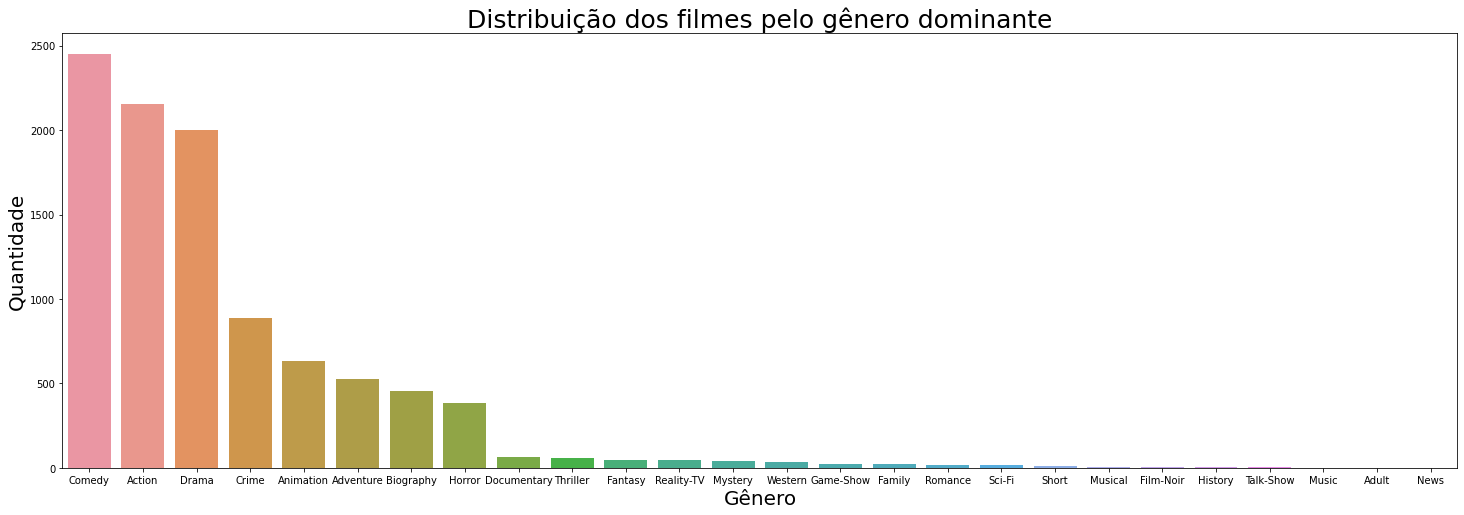

In [ ]:
dommoviegenre_dict = movies_df['dommoviegenre'].value_counts().to_dict()
keys_genre = list(dommoviegenre_dict.keys())
values_genre = list(dommoviegenre_dict.values())

ax = sns.barplot(keys_genre,values_genre)
plt.xlabel("Gênero", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
fig = plt.gcf()
fig.set_size_inches( 25, 8)
plt.savefig('genre.png')
plt.title("Distribuição dos filmes pelo gênero dominante", fontsize=25) 
plt.show();

### Criar dataframe com filmes organizados por gênero

In [ ]:
movies_genre = movies_df.copy()
movies_genre.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_genre.groupby('dommoviegenre')))
df_grouped_genre = pd.concat(groups, axis=0, join='outer')
df_grouped_genre.drop('dommoviegenre', axis = 1, inplace=True)

In [ ]:
df_grouped_genre.head(10)

movieruntime movierating moviescore  \
       movietitle                                                         
Action Zack Snyder's Justice League          240         NaN        NaN   
       Mortal Kombat                         NaN         NaN        NaN   
       Relatos do Mundo                      118         6.8        NaN   
       Monster Hunter                        103         5.3        NaN   
       Guerra dos Tronos                      57         9.3        NaN   
       Boss Level                            100         6.8        NaN   
       Vikings                                44         8.5        NaN   
       O Mandaloriano                         40         8.8        NaN   
       Willy's Wonderland                     88         5.6        NaN   
       Expresso do Amanhã                     60         6.8        NaN   

                                                                      moviedescription  \
       movietitle                                                                        
Action Zack Snyder's Justice League  Zack Snyder's definitive director's cut of Jus...   
       Mortal Kombat                 MMA fighter Cole Young seeks out Earth's great...   
       Relatos do Mundo              A Civil War veteran agrees to deliver a girl, ...   
       Monster Hunter                When Lt. Artemis and her loyal soldiers are tr...   
       Guerra dos Tronos             Nine noble families fight for control over the...   
       Boss Level                    A retired special forces officer is trapped in...   
       Vikings                       Vikings transports us to the brutal and myster...   
       O Mandaloriano                The travels of a lone bounty hunter in the out...   
       Willy's Wonderland            A quiet drifter is tricked into a janitorial j...   
       Expresso do Amanhã            Seven years after the world has become a froze...   

                                          moviedirector movievotes  \
       movietitle                                                    
Action Zack Snyder's Justice League         Zack Snyder        NaN   
       Mortal Kombat                      Simon McQuoid        NaN   
       Relatos do Mundo                 Paul Greengrass      39342   
       Monster Hunter                Paul W.S. Anderson      18101   
       Guerra dos Tronos                            NaN    1776141   
       Boss Level                          Joe Carnahan       3647   
       Vikings                                      NaN     434923   
       O Mandaloriano                               NaN     293951   
       Willy's Wonderland                   Kevin Lewis       6144   
       Expresso do Amanhã                           NaN      28629   

                                                                            moviestars  \
       movietitle                                                                        
Action Zack Snyder's Justice League   Henry Cavill, Ben Affleck, Gal Gadot, Jared Leto   
       Mortal Kombat                 Jessica McNamee, Hiroyuki Sanada, Josh Lawson,...   
       Relatos do Mundo              Tom Hanks, Helena Zengel, Tom Astor, Travis Jo...   
       Monster Hunter                      Milla Jovovich, Tony Jaa, Ron Perlman, T.I.   
       Guerra dos Tronos             Emilia Clarke, Peter Dinklage, Kit Harington, ...   
       Boss Level                    Frank Grillo, Mel Gibson, Naomi Watts, Michell...   
       Vikings                       Katheryn Winnick, Gustaf Skarsgård, Alexander ...   
       O Mandaloriano                Pedro Pascal, Gina Carano, Giancarlo Esposito,...   
       Willy's Wonderland             Nicolas Cage, Emily Tosta, Beth Grant, Ric Reitz   
       Expresso do Amanhã            Daveed Diggs, Mickey Sumner, Alison Wright, Id...   

                                                       moviegenre  \
       movietitle                                              

#### Salvar o dataframe em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Genre.csv')
df_grouped_genre.to_csv('Moveis_Clean_Genre.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 5 - Criar dataframe com filmes organizados por ano de lançamento

### Visualizar a distribuição dos filmes por ano de lançamento

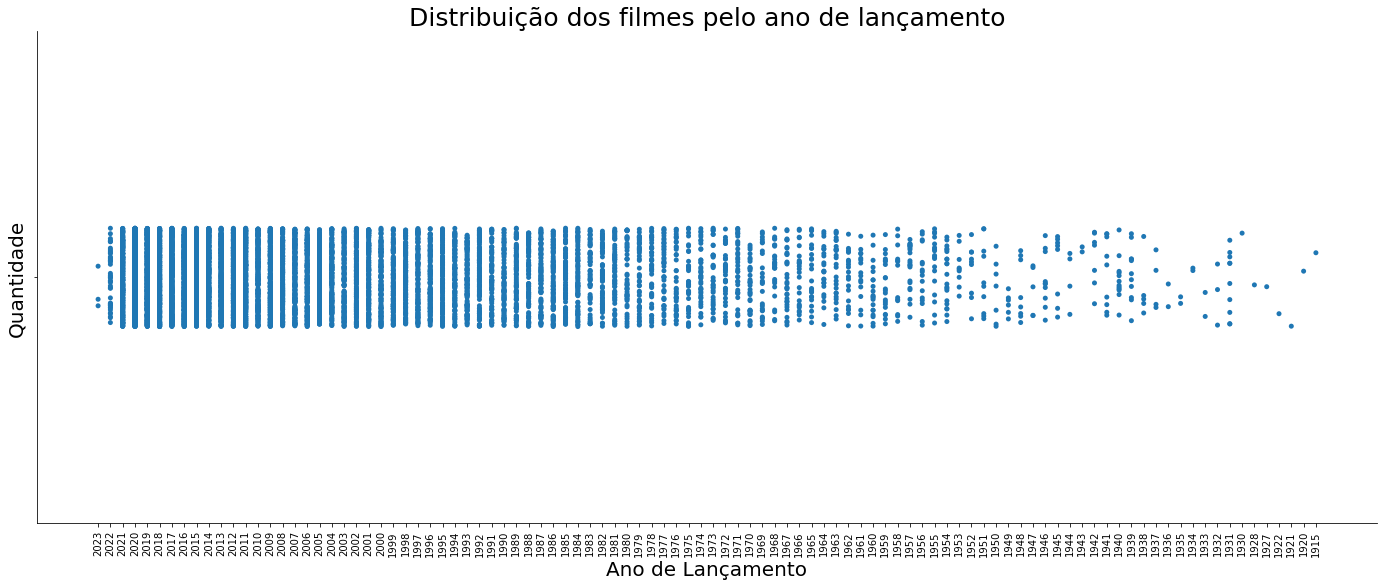

In [ ]:
movies_df_sorted = movies_df.sort_values(by=['moviefirstrun'],ascending=False)
ax = sns.catplot(data = movies_df_sorted, x = 'moviefirstrun')
plt.xlabel("Ano de Lançamento", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches( 20, 8)
plt.title("Distribuição dos filmes pelo ano de lançamento", fontsize=25) 
plt.savefig('date.png')
plt.show();

In [ ]:
movies_df_sorted.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_df_sorted.groupby('moviefirstrun')))
df_grouped_date = pd.concat(groups, axis=0, join='outer')
df_grouped_date.drop('moviefirstrun', axis = 1, inplace=True)

In [ ]:
df_grouped_date.head(20)

movieruntime movierating moviescore  \
     movietitle                                                              
1915 O Nascimento de Uma Nação                  195         6.3        NaN   
1920 O Gabinete do Dr. Caligari                  76         8.1        NaN   
1921 O Garoto                                    68         8.3        NaN   
1922 Nosferatu                                   94         7.9        NaN   
1927 Metrópolis                                 153         8.3        NaN   
1928 O Martírio de Joana D'Arc                  110         8.1        NaN   
1930 Sem Novidade no Front                      152         8.0        NaN   
1931 Só Ela Sabe                                 82         6.5        NaN   
     A Primeira Página                          101         6.7        NaN   
     M, o Vampiro de Dusseldorf                 117         8.3        NaN   
     Drácula                                     75         7.5        NaN   
     A Guarda Secreta                            83         6.3        NaN   
     Frankenstein                                70         7.8        NaN   
     Mulher Sem Algemas                          79         6.1        NaN   
     Amigos e Amantes                            68         5.5        NaN   
     Luzes da Cidade                             87         8.5        NaN   
     Smart Woman                                 68         6.5        NaN   
1932 Scarface: A Vergonha de uma Nação           93         7.8        NaN   
     E o Mundo Marcha                           118         6.3        NaN   
     Monstros                                    64         7.9        NaN   

                                                                         moviedescription  \
     movietitle                                                                             
1915 O Nascimento de Uma Nação          The Stoneman family finds its friendship with ...   
1920 O Gabinete do Dr. Caligari         Hypnotist Dr. Caligari uses a somnambulist, Ce...   
1921 O Garoto                           The Tramp cares for an abandoned child, but ev...   
1922 Nosferatu                          Vampire Count Orlok expresses interest in a ne...   
1927 Metrópolis                         In a futuristic city sharply divided between t...   
1928 O Martírio de Joana D'Arc          In 1431, Jeanne d'Arc is placed on trial on ch...   
1930 Sem Novidade no Front              A German youth eagerly enters World War I, but...   
1931 Só Ela Sabe                        A jealous stage actor disguises himself as a R...   
     A Primeira Página                  A crusading newspaper editor tricks his retiri...   
     M, o Vampiro de Dusseldorf         When the police in a German city are unable to...   
     Drácula                            After a naive real estate agent succumbs to th...   
     A Guarda Secreta                   After rising bootlegger Slaughterhouse Scorpio...   
     Frankenstein                       Dr. Frankenstein dares to tamper with life and...   
     Mulher Sem Algemas                 A young couple lives together out of wedlock, ...   
     Amigos e Amantes                   British Army Captain Geoff Roberts carries on ...   
     Luzes da Cidade                    With the aid of a wealthy erratic tippler, a d...   
     Smart Woman                         A wife turns the tables on her cheating husband.   
1932 Scarface: A Vergonha de uma Nação  An ambitious and nearly insane violent gangste...   
     E o Mundo Marcha                   The evils of alcohol before and during prohibi...   
     Monstros                           A circus' beautiful trapeze artist agrees to m...   

                                                       moviedirector  \
     movietitle                                                        
1915 O Nascimento de Uma Nação                         D.W. Griffith   
1920 O Gabinete do Dr. Caligari                         Rob

#### Salvar o dataframe em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Date.csv')
df_grouped_date.to_csv('Moveis_Clean_Date.zip', index=True, compression=compression_opts, encoding='windows-1252')